# Turnover des collaborateurs à l'AN

## Introduction

Cet étude est basée sur les listes de collaborateurs par députés [publiées par l'Assemblée Nationale](http://www2.assemblee-nationale.fr/qui/liste-des-collaborateurs-par-depute), collectées et transformées par [Regards Citoyens](https://github.com/regardscitoyens/Collaborateurs-Parlement), puis concaténées et opérationnalisées par nos soins.

Elle cherche à quantifier la rotation de l'emploi, ou _turnover_, des collaborateurs en analysant la durée de leurs contrats de travail, ainsi que les caractéristiques des parlementaires qui les emploient.

Nous employons des méthodes issues de la statistique descriptive et inférentielle pour comprendre s'il existe des profils de collaborations entre les parlementaires et les assistants qu'ils emploient.

## Préparation des données

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, linregress

# Fichier généré quotidiennenement par nosdeputes.fr depuis le site de l'AN
csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

# Parsing des dates de contrat, de mandat et de naissance
csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["mandat_debut"] = pd.to_datetime(csv["mandat_debut"])
csv["mandat_fin"] = pd.to_datetime(csv["mandat_fin"])
csv["date_naissance"] = pd.to_datetime(csv["date_naissance"])

# Calcul des temps de contrat, de mandat et de l'âge
csv["contrat_fini"] = (csv["sortie"] != max(csv["sortie"]))
csv["duree_mandat"] = csv["mandat_fin"] - csv["mandat_debut"]
csv["duree_mandat"] = csv["duree_mandat"].apply(lambda a: int(a.total_seconds()/60/60/24))
csv["parlementaire_age"] = (max(csv["sortie"]) - csv['date_naissance']).apply(lambda a: int(a.total_seconds()/60/60/24/365))

# Calcul du nombre de contrats courts par parlementaire
csv["contrat_plus_de_2_mois"] = (( (csv["nombredejours"] < 62) & (csv["contrat_fini"] == True)  ) == False) * 1 
csv["contrat_plus_de_4_mois"] = (( (csv["nombredejours"] < 124) & (csv["contrat_fini"] == True) ) == False) * 1
csv["contrat_plus_de_6_mois"] = (( (csv["nombredejours"] < 186) & (csv["contrat_fini"] == True) ) == False) * 1

#Preparation indicateur Rotation de l'emploi
#https://fr.wikipedia.org/wiki/Rotation_de_l%27emploi
date_rotation = "2017-10-01"
csv["contrat_present_a_date_rotation"] = (csv["entree"] <= date_rotation) & (csv["sortie"] > date_rotation)
csv["contrat_entree_depuis_date_rotation"] = (csv["entree"] > date_rotation)
csv["contrat_sortie_depuis_date_rotation"] = (csv["sortie"] > date_rotation) & (csv["sortie"] < max(csv["sortie"]))


# Suppression des contrat inférieur à 7 jours (problème liés aux ministres)
csv = csv[csv["nombredejours"] > 7]

# Suppression des contrats courts de début de législature (fin de contrat de la législature précédente)
csv = csv[(csv["entree"] < "2017-09-01") & (csv["nombredejours"] < 30) == False]

# Suppression des colonnes inutiles du fichiers d'entrée
csv.drop("collaborateurs", 1, inplace=True)

### Contrôle

In [13]:
csv

,parlementaire,nom_parlementaire,prénom_parlementaire,sexe_parlementaire,collaborateur,nom_collaborateur,prénom_collaborateur,sexe_collaborateur,url_nosdeputes_api,url_institution,...,nombredejours,contrat_fini,duree_mandat,parlementaire_age,contrat_plus_de_2_mois,contrat_plus_de_4_mois,contrat_plus_de_6_mois,contrat_present_a_date_rotation,contrat_entree_depuis_date_rotation,contrat_sortie_depuis_date_rotation
0,Louis Aliot,Aliot,Louis,H,Mme Rania Messiha,Messiha,Rania,F,https://www.nosdeputes.fr/louis-aliot/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,287.0,False,373,48,1,1,1,True,False,False
1,Bertrand Bouyx,Bouyx,Bertrand,H,M. Hugo Guillochin,Guillochin,Hugo,H,https://www.nosdeputes.fr/bertrand-bouyx/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,296.0,False,373,48,1,1,1,True,False,False
2,Stéphane Buchou,Buchou,Stéphane,H,Mme Claire Legrand,Legrand,Claire,F,https://www.nosdeputes.fr/stephane-buchou/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,329.0,False,373,44,1,1,1,True,False,False
3,Cédric Roussel,Roussel,Cédric,H,Mme Caroline Puisségur-Ripet,Puisségur-Ripet,Caroline,F,https://www.nosdeputes.fr/cedric-roussel/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,106.0,False,373,45,1,1,1,False,True,False
4,Isabelle Valentin,Valentin,Isabelle,F,Mme Céline Saby,Saby,Céline,F,https://www.nosdeputes.fr/isabelle-valentin/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,312.0,False,373,56,1,1,1,True,False,False
6,Danielle Brulebois,Brulebois,Danielle,F,M. Eddy Lacroix,Lacroix,Eddy,H,https://www.nosdeputes.fr/danielle-brulebois/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,33.0,True,373,71,0,0,0,False,False,False
7,Laurence Gayte,Gayte,Laurence,F,Mme Frédérique Doutres,Doutres,Frédérique,F,https://www.nosdeputes.fr/laurence-gayte/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,15.0,True,373,52,0,0,0,False,True,True
8,Gisèle Biémouret,Biémouret,Gisèle,F,Mme Valérie Lacabanne,Valérie,Lacabanne,F,https://www.nosdeputes.fr/gisele-biemouret/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,341.0,False,373,66,1,1,1,True,False,False
9,Dominique David,David,Dominique,F,M. Zébulon Bruneteau-Paoletti,Bruneteau-Paoletti,Zébulon,H,https://www.nosdeputes.fr/dominique-david/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,27.0,True,373,55,0,0,0,False,True,True
10,Christophe Lejeune,Lejeune,Christophe,H,M. Stevie Coudray,Coudray,Stevie,H,https://www.nosdeputes.fr/christophe-lejeune/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,292.0,False,373,49,1,1,1,True,False,False


### Nombre de collaborateurs 

In [14]:
len(csv['collaborateur'].unique())

2555

### Rotation de l'emploi au niveau global

La rotation de l'emploi, ou renouvellement du personnel, est [définie comme suit] : ((recrutements + fins de contrats) / 2) / 100.

Celle de l'ensemble des collaborateurs de l'Assemblée sur l'année est de 48%. D'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf), ce taux est sensiblement identique au taux national français.

In [4]:
((csv["contrat_entree_depuis_date_rotation"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation"]*1).sum())/2/(csv["contrat_present_a_date_rotation"]*1).sum()

0.4801708358755339

## Description générale du comportement des députés

### Préparation des données

In [5]:
duree_collaborateurs = csv.groupby(["parlementaire"])[['groupe_sigle']].first().reset_index()
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['sexe_parlementaire']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nom_circo']].first().rename(columns={"nom_circo": "departement"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].median().rename(columns={"nombredejours": "contrat_mediane"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "contrat_moyenne"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['duree_mandat']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_max"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_min"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_2_mois']].sum().rename(columns={"contrat_plus_de_2_mois": "nb_contrats_plus_de_2_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_2_mois'] = duree_collaborateurs['nb_contrats_plus_de_2_mois'] / duree_collaborateurs['nb_collaborateurs']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_4_mois']].sum().rename(columns={"contrat_plus_de_4_mois": "nb_contrats_plus_de_4_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_4_mois'] = duree_collaborateurs['nb_contrats_plus_de_4_mois'] / duree_collaborateurs['nb_collaborateurs']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_6_mois']].sum().rename(columns={"contrat_plus_de_6_mois": "nb_contrats_plus_de_6_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_6_mois'] = duree_collaborateurs['nb_contrats_plus_de_6_mois'] / duree_collaborateurs['nb_collaborateurs']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].count().rename(columns={"nombredejours": "nb_contrat_fini"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs['nb_contrat_fini'].fillna(0, inplace=True)
duree_collaborateurs['ratio_contrat_fini'] = duree_collaborateurs['nb_contrat_fini'] / duree_collaborateurs['nb_collaborateurs']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_fini_max"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_fini_min"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['ancien_depute']].first().reset_index(), on="parlementaire")
duree_collaborateurs["ratio_contrat_mandat"] = duree_collaborateurs["contrat_mediane"] / duree_collaborateurs["duree_mandat"]
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nb_mandats']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['parlementaire_age']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.sort_values("ratio_plus_de_2_mois")#sort_values("contrat le plus long")

#Rotation emploi
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation', 'contrat_entree_depuis_date_rotation', 'contrat_sortie_depuis_date_rotation']].sum().reset_index(), on="parlementaire")
duree_collaborateurs["emploi_rotation"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation']+duree_collaborateurs['contrat_sortie_depuis_date_rotation'])/2)/duree_collaborateurs['contrat_present_a_date_rotation']
duree_collaborateurs["emploi_taux_depart"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation']/duree_collaborateurs['contrat_present_a_date_rotation']
duree_collaborateurs["emploi_taux_arrivee"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation']/duree_collaborateurs['contrat_present_a_date_rotation']

duree_collaborateurs.to_csv("../data/duree_collaborateur.csv")

### Durée des contrats de collaborateurs

Certains députés ont des collaborateurs fidèles. Le graphique suivant représente le contrat le plus long de chacun des parlementaires. Les fidèles sont représentés par le palier supérieur à droite du graphique suivant : la durée de leur contrat est égale à la durée de la législature.

Le second palier à 300 jours représente probablement les fidèles des parlementaires suppléants de ministre du gouvernement Philippe 1.

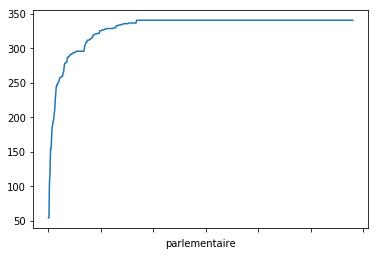

In [6]:
duree_collaborateurs.sort_values("contrat_max").set_index("parlementaire")["contrat_max"].plot()

Le graphique infra représente le contrat le plus court pour chacun des parlementaire.

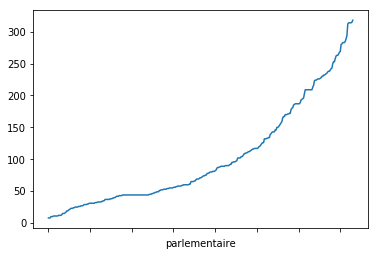

In [7]:
duree_collaborateurs.sort_values("contrat_fini_min").set_index("parlementaire")["contrat_fini_min"].plot()

Certains parlementaires n'ont aucun contrat court, ils n'ont que des collaborateurs fidèles en contrat de longue durée. D'autres se sont parfois séparé d'un collaborateur après moins de 20 jours.

### Rotation de l'emploi

La rotation de l'emploi moyenne des collaborateur d'un député est de 57%. Au niveau national, elle est de 58,8% dans les établissements de 1 à 9 salariés d'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf).

La répartition par quartile montre en revanche que 25% des députés ont une rotation d'emploi nettemment au dessus de la moyenne nationale.

In [8]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation"] < 100]["emploi_rotation"].describe()

count    568.000000
mean       0.578370
std        0.703150
min        0.000000
25%        0.166667
50%        0.333333
75%        0.750000
max        6.500000
Name: emploi_rotation, dtype: float64

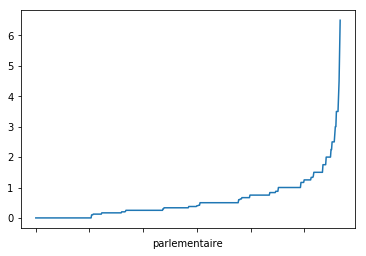

In [9]:
duree_collaborateurs.sort_values("emploi_rotation").set_index("parlementaire")["emploi_rotation"].plot()
#duree_collaborateurs["emploi_rotation"].plot()

## Les députés et le turnover de leurs collaborateurs

Le tri infra des parlementaires par la durée du contrat de collaborateur le plus long fait remonter ceux qui gardent peu de collaborateurs sur le long terme : leurs collaborateurs n'ont pas beaucoup d'ancienneté, **ils n'ont pas de fidèles**

In [10]:
# Suppression des députés nouvellement élus avant le tri
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('contrat_max').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "ratio_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,nb_contrat_fini,ratio_contrat_fini,contrat_present_a_date_rotation,contrat_entree_depuis_date_rotation,contrat_sortie_depuis_date_rotation,emploi_rotation,emploi_taux_depart,emploi_taux_arrivee
43,José Evrard,NI,H,Pas-de-Calais,100.0,101.428571,7,154.0,7.0,1.000000,1.0,6.0,7.0,6.500000,7.000000,6.000000
28,Anissa Khedher,LREM,F,Rhône,89.0,107.333333,6,185.0,4.0,0.666667,3.0,3.0,4.0,1.166667,1.333333,1.000000
502,Loïc Dombreval,LREM,H,Alpes-Maritimes,163.0,161.750000,4,189.0,2.0,0.500000,2.0,2.0,2.0,1.000000,1.000000,1.000000
344,Marie Lebec,LREM,F,Yvelines,187.5,185.750000,4,197.0,1.0,0.250000,1.0,3.0,1.0,2.000000,1.000000,3.000000
161,Valérie Petit,LREM,F,Nord,132.0,129.714286,7,204.0,4.0,0.571429,3.0,3.0,3.0,1.000000,1.000000,1.000000
327,Sandra Marsaud,LREM,F,Charente,99.0,113.500000,6,211.0,3.0,0.500000,2.0,4.0,3.0,1.750000,1.500000,2.000000
14,Florence Lasserre-David,MODEM,F,Pyrénées-Atlantiques,57.0,112.400000,5,225.0,3.0,0.600000,1.0,3.0,2.0,2.500000,2.000000,3.000000
223,Michel Vialay,LR,H,Yvelines,139.5,155.000000,4,236.0,2.0,0.500000,1.0,3.0,2.0,2.500000,2.000000,3.000000
141,Thierry Solère,LREM,H,Hauts-de-Seine,141.5,152.333333,6,245.0,4.0,0.666667,2.0,3.0,3.0,1.500000,1.500000,1.500000
5,Jérôme Nury,LR,H,Orne,113.0,120.714286,7,249.0,3.0,0.428571,0.0,7.0,3.0,inf,inf,inf


Le tri croissant par le pourcentage de contrats de plus de 6 mois fait remonter les députés ayant des fidèles mais cumulant de nombreux contrats de mois de 6 mois.

In [11]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_plus_de_6_mois').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini,ratio_contrat_fini,contrat_present_a_date_rotation,contrat_entree_depuis_date_rotation,contrat_sortie_depuis_date_rotation,emploi_rotation,emploi_taux_depart,emploi_taux_arrivee
43,José Evrard,NI,H,Pas-de-Calais,100.0,101.428571,7,154.0,0.000000,7.0,1.000000,1.0,6.0,7.0,6.500000,7.000000,6.000000
0,Alexandre Freschi,LREM,H,Lot-et-Garonne,119.0,144.333333,6,341.0,0.333333,4.0,0.666667,2.0,4.0,4.0,2.000000,2.000000,2.000000
141,Thierry Solère,LREM,H,Hauts-de-Seine,141.5,152.333333,6,245.0,0.333333,4.0,0.666667,2.0,3.0,3.0,1.500000,1.500000,1.500000
2,Danielle Brulebois,LREM,F,Jura,90.0,97.555556,9,294.0,0.333333,6.0,0.666667,3.0,3.0,3.0,1.000000,1.000000,1.000000
28,Anissa Khedher,LREM,F,Rhône,89.0,107.333333,6,185.0,0.333333,4.0,0.666667,3.0,3.0,4.0,1.166667,1.333333,1.000000
21,Frédérique Lardet,LREM,F,Haute-Savoie,122.5,148.333333,6,341.0,0.333333,4.0,0.666667,2.0,4.0,4.0,2.000000,2.000000,2.000000
58,Cédric Roussel,LREM,H,Alpes-Maritimes,109.5,137.250000,8,312.0,0.375000,5.0,0.625000,3.0,4.0,4.0,1.333333,1.333333,1.333333
17,Laurence Maillart-Méhaignerie,LREM,F,Ille-et-Vilaine,79.5,113.875000,8,341.0,0.375000,5.0,0.625000,2.0,6.0,5.0,2.750000,2.500000,3.000000
160,Laure de La Raudière,UAI,F,Eure-et-Loir,151.0,173.571429,7,341.0,0.428571,4.0,0.571429,3.0,3.0,3.0,1.000000,1.000000,1.000000
161,Valérie Petit,LREM,F,Nord,132.0,129.714286,7,204.0,0.428571,4.0,0.571429,3.0,3.0,3.0,1.000000,1.000000,1.000000


Trier les parlementaires par la proportion de contrats clos parmis tous leurs contrats de collaborateur (contrats très courts et parlementaires nouvellement élus exclus) permet d'isoler ceux s'étant souvent séparé de leur personnel.

In [12]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_contrat_fini', ascending=False).drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "contrat_mediane", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "ratio_contrat_fini", "contrat_moyenne", "nb_collaborateurs", "contrat_max", "ratio_plus_de_6_mois", "nb_contrat_fini", "rotation_emploi"]].head(15)

KeyError: "['rotation_emploi'] not in index"

In [ ]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation"] < 100].sort_values(['emploi_taux_depart', "emploi_rotation"], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_rotation", "emploi_taux_depart", "emploi_taux_arrivee", 'contrat_present_a_date_rotation', 'contrat_entree_depuis_date_rotation', 'contrat_sortie_depuis_date_rotation', "ratio_contrat_fini", "contrat_moyenne", "nb_collaborateurs", "contrat_max", "ratio_plus_de_6_mois", "nb_contrat_fini"]].head(50)

Près de la moitié des parlementaires ont déjà mis fin à un contrat dans une durée de moins de 4 mois : la période d'essai d'un CDI de collaborateur est de 2 mois.

In [ ]:
duree_collaborateurs[duree_collaborateurs["contrat_fini_min"] < 120]["parlementaire"].count() * 100 / duree_collaborateurs["parlementaire"].count()

## L'influence des groupes politiques

Les durées moyennes de contrat par groupe politique pointe les non-inscrits comme le groupe parlementaires qui garde le moins longtemps ses collaborateurs.

In [ ]:
duree_collaborateurs[["groupe_sigle", "contrat_mediane"]].groupby("groupe_sigle").mean().sort_values("contrat_mediane")

# L'influence du sexe

Les durées médianes des contrats de collaborateurs femmes et hommes indiquent que les femmes restent en poste sensiblement plus longtemps, alors que collaborer avec une parlementaire femme mène à des contrats plus courts.

In [ ]:
collab_femme_vs_homme = csv.groupby(["sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].median()
collab_femme_vs_homme

In [ ]:
depute_femme_vs_homme = csv.groupby(["sexe_parlementaire"])[['nombredejours', 'sexe_collaborateur']].median()
depute_femme_vs_homme

On observe que seules les parlementaires femmes montrent une préférences de genre envers les hommes pour leurs collaborateurs, mais cela n'influe pas sur la durée des contrats des collaborateurs.

In [ ]:
duree_moy_sexe = csv.groupby(["parlementaire", "sexe_parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].mean()
nb_collab_sexe = csv.groupby(["parlementaire", "sexe_collaborateur"])[['collaborateur']].count().rename(columns={'collaborateur': 'nb_collaborateurs'})
stats_sexe = duree_moy_sexe.reset_index().merge(nb_collab_sexe.reset_index(), on=["parlementaire", "sexe_collaborateur"])
stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nombredejours"]].mean()

In [ ]:
nb = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].sum()
moy = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].mean()["nb_collaborateurs"].rename(columns={"nb_collaborateurs": "nb_collaborateurs_moyen"})

moy.reset_index().merge(nb.reset_index(), on=["sexe_parlementaire", "sexe_collaborateur"]).set_index(["sexe_parlementaire", "sexe_collaborateur"])


## Tests statistiques sur les parlementaires

### Préparation des données

In [ ]:
# Dichotomisation des variables
duree_tt = duree_collaborateurs
duree_tt["parlementaire_femme"] = (duree_tt["sexe_parlementaire"] == "F") * 1
duree_tt["parlementaire_homme"] = (duree_tt["sexe_parlementaire"] == "H") * 1
duree_tt["parlementaire_has_autre_mandats"] = (duree_tt["nb_mandats"] > 1) * 1
duree_tt["ancien_depute"] = (duree_tt["ancien_depute"]) * 1
for grp in duree_tt["groupe_sigle"].unique():
    duree_tt["groupe_"+grp] = (duree_tt["groupe_sigle"] == grp) * 1

# Inputation des valeurs manquantes
duree_tt["contrat_fini_min"].fillna(150, inplace=True)
duree_tt["contrat_fini_max"].fillna(150, inplace=True)

### Test de significativité des variables dichotomiques

Pour chacune des variables booléennes décrivant les parlementaires (sexe, groupes, etc.) on effectue un test indiquant son effet sur la durée moyenne des contrats de ses collaborateurs.

In [ ]:
for i in duree_tt.drop(["nb_contrat_fini", "ratio_contrat_fini","contrat_mediane", "contrat_moyenne", "nb_collaborateurs", "parlementaire_age", "duree_mandat", "nb_mandats","contrat_max", "contrat_min", "ratio_contrat_mandat", "contrat_fini_max", "contrat_fini_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois"], 1).columns[4:]:
    cat2 = duree_tt[duree_tt[i] == 0]["contrat_moyenne"]
    cat1 = duree_tt[duree_tt[i] == 1]["contrat_moyenne"]

    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

### Tests de régression sur les variables continues

Pour chacune des variables continues, telles que l'âge ou le nombre de collaborateurs, décrivant les parlementaires, on effectue un test de régression qui nous indique son effet sur la durée moyenne de ses contrats.

In [ ]:
tt = {}
for i in duree_tt.columns[4:].drop(["contrat_moyenne", "contrat_mediane", "duree_mandat", "ratio_plus_de_2_mois", "ratio_plus_de_4_mois", "ratio_plus_de_6_mois", "ratio_contrat_fini"], 1):
    tt[i] = linregress(duree_tt["contrat_moyenne"], duree_tt[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(duree_tt["contrat_moyenne"], duree_tt[i], 'o', label=i)
        plt.plot(duree_tt["contrat_moyenne"], tt[i].intercept + tt[i].slope*duree_tt["contrat_moyenne"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Tests statistiques sur les collaborateurs

### Préparation des données

In [ ]:
tous_collaborateurs = csv.merge(duree_collaborateurs.drop([ 'groupe_sigle', 'sexe_parlementaire', 'duree_mandat', 'nb_mandats', 'parlementaire_age', 'ancien_depute'], 1), on="parlementaire")
tous_collaborateurs["collaborateur_femme"] = (tous_collaborateurs["sexe_collaborateur"] == "F") * 1
tous_collaborateurs["collaborateur_homme"] = (tous_collaborateurs["sexe_collaborateur"] == "H") * 1
tous_collaborateurs.to_csv("../data/turnover_collaborateurs_variables.csv")
tous_collaborateurs = tous_collaborateurs.drop(["entree", "sortie"], 1)

tous_collaborateurs = tous_collaborateurs.drop(['groupe_sigle', 'parti_ratt_financier', 'sites_web','emails', 'adresses', 'autres_mandats', 'anciens_autres_mandats', 'anciens_mandats', 'profession', 'place_en_hemicycle', 'url_an', 'id_an', 'slug', 'url_nosdeputes', "duree_mandat", "departement"], 1)
#tous_collaborateurs.columns[24:]

### Test de significativité des variables dichotomiques

In [ ]:
for i in tous_collaborateurs.columns[24:].drop(["contrat_fini", "contrat_plus_de_2_mois", "nombredejours","contrat_plus_de_4_mois", "contrat_plus_de_6_mois","parlementaire_age","contrat_mediane","contrat_moyenne","nb_collaborateurs","contrat_max","contrat_min","nb_contrats_plus_de_2_mois","ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois","nb_contrat_fini","ratio_contrat_fini","contrat_fini_max","contrat_fini_min","ratio_contrat_mandat"], 1):
    cat2 = tous_collaborateurs[tous_collaborateurs[i] == 0]["nombredejours"]
    cat1 = tous_collaborateurs[tous_collaborateurs[i] == 1]["nombredejours"]
    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

### Tests de régression sur les variables continues

In [ ]:
tt = {}
for i in tous_collaborateurs.drop(["nombredejours", "contrat_moyenne", "contrat_mediane", "ratio_plus_de_2_mois","ratio_plus_de_4_mois","ratio_plus_de_6_mois"], 1).columns[24:]:
    tt[i] = linregress(tous_collaborateurs["nombredejours"], tous_collaborateurs[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(tous_collaborateurs["nombredejours"], tous_collaborateurs[i], 'o', label=i)
        plt.plot(tous_collaborateurs["nombredejours"], tt[i].intercept + tt[i].slope*tous_collaborateurs["nombredejours"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Conclusions